# Resampling Images

## Overview

### Define output image information

* When resampling an image, we must first define output the image information, i.e. the *Origin*, *Spacing*, *Direction*, and *Size*.
* This determines the grid of samples where the output will be sampled.
* It does need not need to be the same as the input image.

![Resampling output information](Data/ResampleOutputInformation.png)

### Finding a resampled pixel's value

For each pixel in the output image:

1. Transform its index value to its location in physical space.
2. Apply an optional spatial transformation.
3. Transform the physical point location to a continuous index on the image to be resampled.
4. Interpolate from neighboring pixels.

![Common reference system](Data/CommonReferenceSystem.png)

### Different interpolators

<a href="http://www.itk.org/SimpleITKDoxygen/html/namespaceitk_1_1simple.html#a7cb1ef8bd02c669c02ea2f9f5aa374e5">There are many interpolators available</a>:
<ul>
<li> sitkNearestNeighbor </li>
<li> sitkLinear </li>
<li> sitkBSpline </li>
<li> sitkGaussian </li>
<li> sitkHammingWindowedSinc </li>
<li> sitkCosineWindowedSinc </li>
<li> sitkWelchWindowedSinc </li>
<li> sitkLanczosWindowedSinc </li>
<li> sitkBlackmanWindowedSinc </li>
</ul>

### Resampling and the registration framework

**Registration** involves **sampling** the two images to be registered with at **spatial transform**. The sampled values are compared with a **similarity metric**.  An **optimizer** is used to improve the spatial transformation parameters iteratively until the samples coorespond.

![Registration framework](Data/ITKv4RegistrationComponentsDiagram.svg)

## Tutorial

In [1]:
import SimpleITK as sitk

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

Read a 3D input image.

In [4]:
input_image = sitk.ReadImage('Data/NESb_C2_TP1.tiff')
print(input_image.GetSize())

(1024, 1024, 9)


View one of its slices.

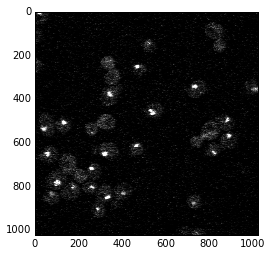

In [9]:
input_slice = input_image[:,:,4]
plt.imshow(sitk.GetArrayFromImage(input_slice), cmap='gray')

Create a resampler.

In [11]:
resampler = sitk.ResampleImageFilter()

What are the options that can be set on the `resampler`?

In [ ]:
# Uncomment the line below and place the cursor after the "t" in "Set"
# Then, press the TAB key.
#resampler.Set

We can either set use a *reference image* to determine the output image pixel sampling grid, or we can set desired output image information manually.

Here we will make the output image size half of the input image size in each direction.

In [19]:
origin = input_image.GetOrigin()
resampler.SetOutputOrigin(origin)

direction = input_image.GetDirection()
resampler.SetOutputDirection(direction)

spacing = input_image.GetSpacing()
resampler.SetOutputSpacing(spacing)

size = list(input_image.GetSize())
size[0] = int(size[0] / 2)
size[1] = int(size[1] / 2)
resampler.SetSize(size)
print(size)

[512, 512, 9]


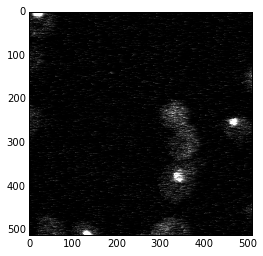

In [23]:
resampled_image = resampler.Execute(input_image)
plt.imshow(sitk.GetArrayFromImage(resampled_image[:,:,4]), cmap='gray')

We can also apply a spatial transform in the resampling process.

In [27]:
dimension = 3
translation = (-100.0, -200.0, 0.0)
transform = sitk.TranslationTransform(dimension, translation)
resampler.SetTransform(transform)

<SimpleITK.SimpleITK.ResampleImageFilter; proxy of <Swig Object of type 'itk::simple::ResampleImageFilter::Self *' at 0x7f4635497630> >

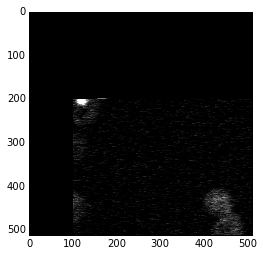

In [28]:
resampled_image = resampler.Execute(input_image)
plt.imshow(sitk.GetArrayFromImage(resampled_image[:,:,4]), cmap='gray')

When the input image is sampled outside of its domain, a *default pixel value* is returned.

In [30]:
resampler.SetDefaultPixelValue(150)

<SimpleITK.SimpleITK.ResampleImageFilter; proxy of <Swig Object of type 'itk::simple::ResampleImageFilter::Self *' at 0x7f465cb678d0> >

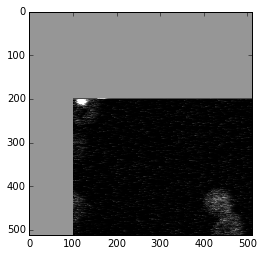

In [31]:
resampled_image = resampler.Execute(input_image)
plt.imshow(sitk.GetArrayFromImage(resampled_image[:,:,4]), cmap='gray')

Finally, we can also change the interpolator used.  The default is a bi-linear interpolator for 2D images and a tri-linear interpolator for 3D images.

In [34]:
resampler.SetInterpolator(sitk.sitkNearestNeighbor)

<SimpleITK.SimpleITK.ResampleImageFilter; proxy of <Swig Object of type 'itk::simple::ResampleImageFilter::Self *' at 0x7f46357d8690> >

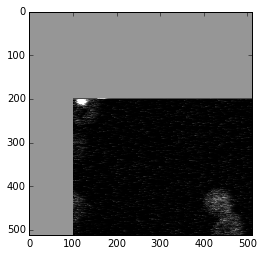

In [35]:
resampled_image = resampler.Execute(input_image)
plt.imshow(sitk.GetArrayFromImage(resampled_image[:,:,4]), cmap='gray')

## Exercises